In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score, accuracy_score)

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df = pd.read_csv("radiomics_results_2.csv")

# Add label: 0 = benign, 1 = malignant
df["label"] = df["ID"].apply(lambda x: 0 if "benign" in x.lower() else 1)

# Remove diagnostic columns-Radiomics generates many "diagnostics_" columns that contain metadata, not features
df = df.loc[:, ~df.columns.str.startswith("diagnostics_")]

# Prepare X and y
y = df["label"] # target variable x and y
X = df.drop(columns=["ID", "label"]) # all radiomics features.


--- PERFORMANCE METRICS ---
Accuracy: 0.9433
ROC-AUC Score: 0.9892

Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      0.98      0.96       131
   Malignant       0.95      0.87      0.91        63

    accuracy                           0.94       194
   macro avg       0.94      0.93      0.93       194
weighted avg       0.94      0.94      0.94       194



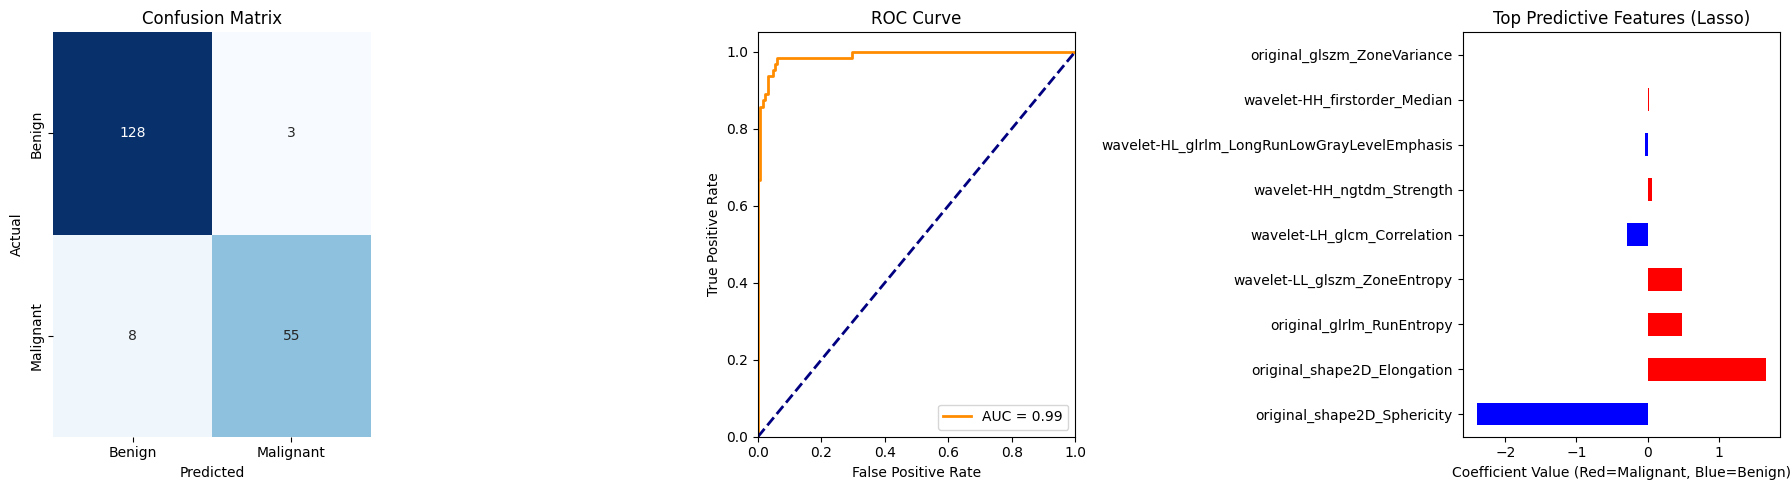

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 2. TRAIN LASSO MODEL ---
# C=0.1 is a good starting point for feature selection
model = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42)
model.fit(X_train_scaled, y_train)

# --- 3. PRINT METRICS ---
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1] # Probability for ROC curve

print("\n--- PERFORMANCE METRICS ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

# --- 4. GENERATE PLOTS ---
plt.figure(figsize=(18, 5))

# Plot A: Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot B: ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot C: Feature Importance (Top 10)
plt.subplot(1, 3, 3)
coefs = pd.Series(model.coef_[0], index=X.columns)
# Filter for non-zero features and sort by magnitude
important_feats = coefs[coefs != 0].abs().sort_values(ascending=False).head(10)
# Plot the actual signed values of those top absolute features
final_plot_feats = coefs[important_feats.index] 

final_plot_feats.plot(kind='barh', color=np.where(final_plot_feats > 0, 'r', 'b'))
plt.title('Top Predictive Features (Lasso)')
plt.xlabel('Coefficient Value (Red=Malignant, Blue=Benign)')

plt.tight_layout()
plt.show()

In [24]:
from sklearn.model_selection import StratifiedKFold 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_scores = []

for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    stratified_scores.append(accuracy_score(y_test, y_pred))

print(f"Stratified K-Fold scores: {stratified_scores}")
print(f"Mean: {np.mean(stratified_scores):.4f}, Std: {np.std(stratified_scores):.4f}")

Stratified K-Fold scores: [0.8992248062015504, 0.9457364341085271, 0.937984496124031, 0.9457364341085271, 0.9534883720930233]
Mean: 0.9364, Std: 0.0192


Tuning hyperparameters... this may take a moment.

--- OPTIMIZATION RESULTS ---
Best Parameters: {'C': np.float64(0.21544346900318834), 'penalty': 'l1'}
Best CV Score (AUC): 0.9833

Test Set Accuracy: 0.9485
Test Set AUC: 0.9878


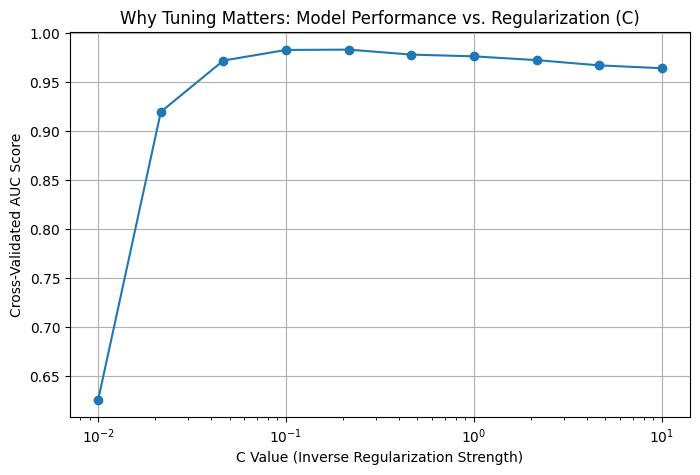

In [9]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# --- 1. SETUP GRID SEARCH ---
# We will test two types of Logistic Regression:
# 'l1' (Lasso) and 'elasticnet' (Hybrid)

# Define the model (solver='saga' is required for elasticnet)
base_model = LogisticRegression(solver='saga', max_iter=5000, random_state=42)

# Define the "grid" of settings to test
param_grid = [
    # Case A: Lasso (L1) Tuning
    {
        'penalty': ['l1'],
        'C': np.logspace(-2, 1, 10)  # Tries 10 values from 0.01 to 10
    },
    # Case B: Elastic Net Tuning
    {
        'penalty': ['elasticnet'],
        'C': np.logspace(-2, 1, 10),
        'l1_ratio': [0.1, 0.5, 0.9]  # 0.1 = mostly Ridge, 0.9 = mostly Lasso
    }
]

print("Tuning hyperparameters... this may take a moment.")

# --- 2. RUN GRID SEARCH ---
# cv=5 means 5-Fold Cross-Validation (robust checking)
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# --- 3. GET THE WINNER ---
best_model = grid_search.best_estimator_

print("\n--- OPTIMIZATION RESULTS ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score (AUC): {grid_search.best_score_:.4f}")

# --- 4. EVALUATE ON TEST SET ---
# Now we test the "Winner" on the data it has never seen (X_test)
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nTest Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test Set AUC: {roc_auc_score(y_test, y_prob):.4f}")

# --- 5. PLOT THE TUNING CURVE (Visualizing the "Sweet Spot") ---
results = pd.DataFrame(grid_search.cv_results_)
lasso_results = results[results['param_penalty'] == 'l1']

plt.figure(figsize=(8, 5))
plt.semilogx(lasso_results['param_C'], lasso_results['mean_test_score'], marker='o')
plt.title('Why Tuning Matters: Model Performance vs. Regularization (C)')
plt.xlabel('C Value (Inverse Regularization Strength)')
plt.ylabel('Cross-Validated AUC Score')
plt.grid(True)
plt.show()

Total Features: 474
Features Selected by Best Model: 26


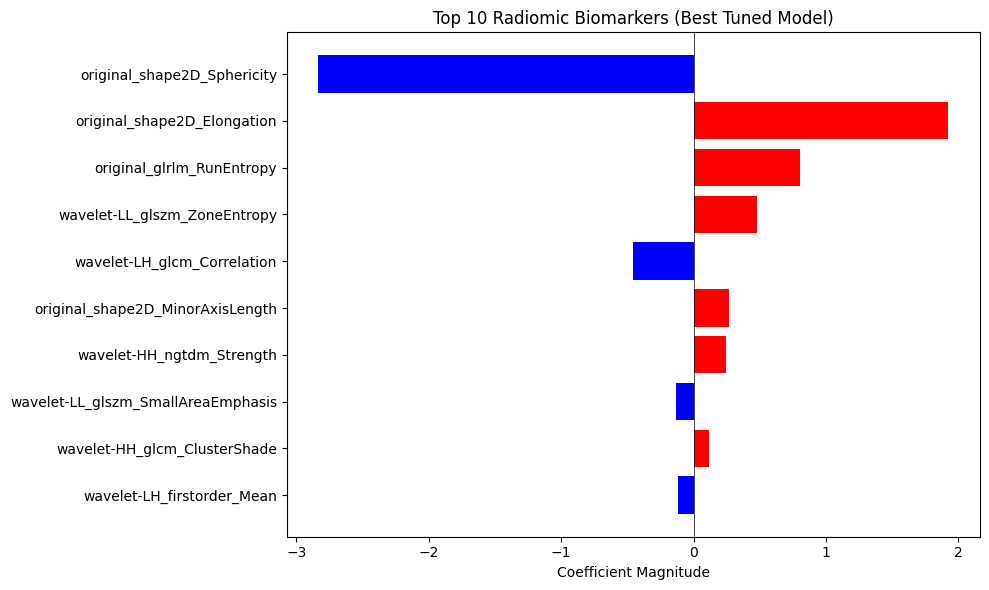

In [10]:
best_model = grid_search.best_estimator_

# 2. Get the coefficients
# (Since we scaled X_train separately in the previous step, we can access coef_ directly)
coefs = best_model.coef_.flatten()

# 3. Match coefficients to feature names
feature_names = X.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Abs_Coef': np.abs(coefs)
})

# 4. Filter for non-zero features (the ones Lasso kept)
selected_features = feature_importance[feature_importance['Coefficient'] != 0]
selected_features = selected_features.sort_values(by='Abs_Coef', ascending=False)

print(f"Total Features: {len(feature_names)}")
print(f"Features Selected by Best Model: {len(selected_features)}")

# 5. Visualize the Top 10 Biomarkers
plt.figure(figsize=(10, 6))
# We take the top 10 by magnitude
top_10 = selected_features.head(10)

# Color code: Red = Malignant (Pos), Blue = Benign (Neg)
colors = ['red' if c > 0 else 'blue' for c in top_10['Coefficient']]

plt.barh(top_10['Feature'], top_10['Coefficient'], color=colors)
plt.title('Top 10 Radiomic Biomarkers (Best Tuned Model)')
plt.xlabel('Coefficient Magnitude')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis() # Put the most important at the top
plt.tight_layout()
plt.show()

# 6. Save for your paper/report
selected_features.to_csv("biomarkers_lasso_optimized.csv", index=False)

--- Naive Bayes Results ---
Accuracy: 0.7423
AUC:      0.7939

--- SVM (RBF Kernel) Results ---
Accuracy: 0.8454
AUC:      0.8855


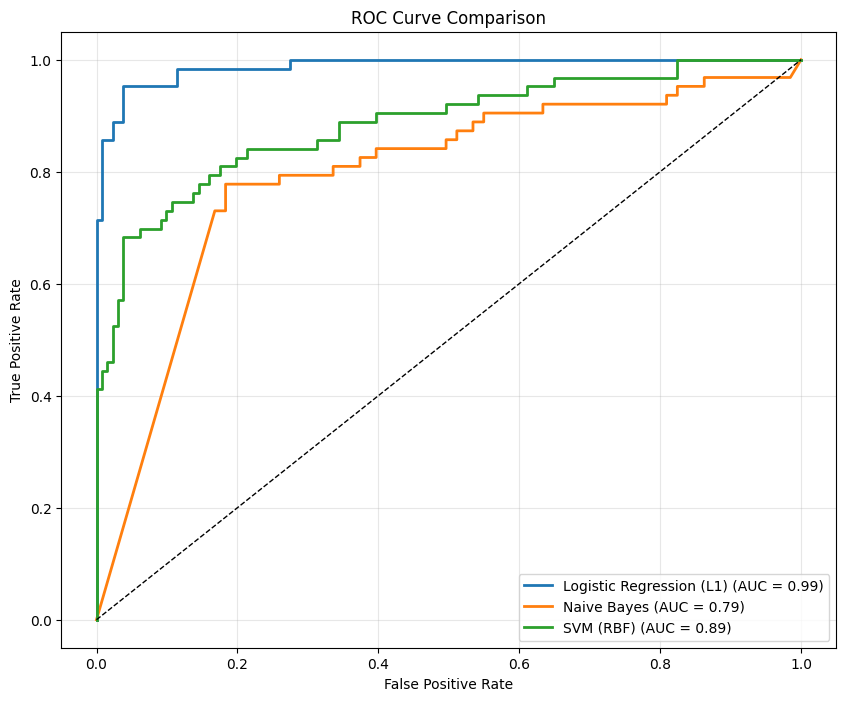

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# --- 1. NAIVE BAYES ---
# Gaussian Naive Bayes (No hyperparameters to tune usually)
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

nb_pred = nb_model.predict(X_test_scaled)
nb_prob = nb_model.predict_proba(X_test_scaled)[:, 1]

print("--- Naive Bayes Results ---")
print(f"Accuracy: {accuracy_score(y_test, nb_pred):.4f}")
print(f"AUC:      {roc_auc_score(y_test, nb_prob):.4f}")

# --- 2. SUPPORT VECTOR MACHINE (SVM) ---
# We use the RBF kernel to capture non-linear patterns
svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

svm_pred = svm_model.predict(X_test_scaled)
svm_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- SVM (RBF Kernel) Results ---")
print(f"Accuracy: {accuracy_score(y_test, svm_pred):.4f}")
print(f"AUC:      {roc_auc_score(y_test, svm_prob):.4f}")

# --- 3. COMPARISON PLOT ---
plt.figure(figsize=(10, 8))

# Plot Logistic Regression (L1) - reusing 'best_model' from previous step
lr_prob = best_model.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (L1) (AUC = {roc_auc_score(y_test, lr_prob):.2f})', lw=2)

# Plot Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_prob)
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_score(y_test, nb_prob):.2f})', lw=2)

# Plot SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_prob)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (RBF) (AUC = {roc_auc_score(y_test, svm_prob):.2f})', lw=2)

# Graph Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=1) # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()